In [354]:
import pandas as pd
import tensorflow as tf
import keras
import os.path
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

import keras.backend as K
from keras.utils import np_utils
from keras.callbacks import Callback


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from IPython.core.debugger import Pdb

from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# show warnings always
# import warnings
# warnings.filterwarnings('always')

print(tf.VERSION)
print(keras.__version__)

1.9.0
2.2.2


# Read-in data

In [170]:
train_pd = pd.read_csv('./datasets/train.csv', sep=',', header=0)

## Getting to know the data

Check if there is more than 1 household head per household

Group by *idhogar* (household key) and then check column *parentesco1*

In [ ]:
idhogar_aggregated = train_pd.groupby('idhogar').parentesco1.sum()

In [ ]:
idhogar_aggregated[idhogar_aggregated != 1]

There are 15 households with no household head

Check if the poverty label is the same for all members of a household

In [ ]:
target_aggregated = train_pd.groupby('idhogar').Target.aggregate(['min', 'max'])

target_aggregated['poverty_different'] = target_aggregated['min'] != target_aggregated['max']
target_aggregated.loc[target_aggregated['poverty_different']].head(10)

It is not, meaning that members of a given household can have different poverty levels.

In [ ]:
train_pd.loc[train_pd['idhogar'] == '0172ab1d9']

Check if houses that have been fully paid have a montly payment - they should not.

In [ ]:
train_pd.loc[(train_pd['tipovivi1'] == 1) & (~np.isnan(train_pd['v2a1']))] # GOOD

In [ ]:
len(train_pd.columns)

# Prepare data

Drop some unneeded columns

In [171]:
# the columns (SQBage, agesq) and (tamhog, hhsize, hogar_total) are identical - REMOVE THEM
train_pd.drop(columns=['SQBage', 'tamhog', 'hogar_total'], inplace=True)

# drop interaction columns ['edjefe', 'edjefa']
train_pd.drop(columns=['edjefe', 'edjefa', 'SQBedjefe'], inplace=True)
# drop dependency and its square - mixed numerical and alphanumeric values, unclear contribution
train_pd.drop(columns=['dependency', 'SQBdependency'], inplace=True)

# Drop all the squared features
train_pd.drop(columns=['agesq', 'SQBhogar_total', 'SQBhogar_nin', 'SQBovercrowding', 'SQBmeaned'], inplace=True)

# Drop string columns
train_pd.drop(columns=['idhogar', 'Id'], inplace=True)

len(train_pd.columns)

128

Check the target labels and rebalance if necessary

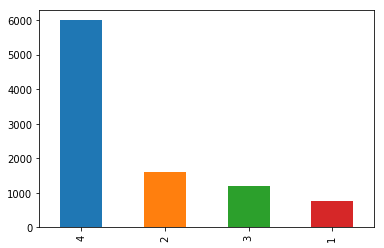

In [5]:
train_pd.Target.value_counts().plot(kind='bar')

In [ ]:
# compute the disbalance
print(train_pd.Target.value_counts())
print(train_pd.Target.value_counts(normalize=True))
print(len(train_pd))

## Train-test split

In [172]:
# Resampling methods

def SMOTE_resample(x, y):
    max_label = pd.Series(y).value_counts().iloc[0]
    sm = SMOTE(random_state=42, ratio={1:max_label, 2:max_label, 3:max_label})
    x_res, y_res = sm.fit_sample(x, y)
    return x_res, y_res

def naive_resample(x, y):
    # simply sample with replacement
    max_label = pd.Series(y).value_counts().iloc[0]
    rus = RandomOverSampler(random_state=42, ratio={1:max_label, 2:max_label, 3:max_label})
    x_res, y_res = rus.fit_sample(x, y)
    return x_res, y_res


In [173]:
# prepare the data
# split 

# convert all NaNs to 0 - big assumption
train_pd = train_pd.fillna(0)


In [243]:
def CV_monte_carlo(model, training_data, N=10, trainining_size=0.8):
    f1_scores = []
    best_model = None
    cm = None
    for n in range(N):
        # split
        input_train, input_test, \
        target_train, target_test = train_test_split(training_data.loc[:, ~training_data.columns.isin(['Target'])].values, 
                                                     training_data['Target'].values, test_size=1-trainining_size)
        input_train_rs, target_train_rs = naive_resample(input_train, target_train)
        input_train_smote, target_train_smote = SMOTE_resample(input_train, target_train)
        # fit and evaluate model
        model.fit(input_train_rs, target_train_rs)
        predicted = model.predict(input_test)
        # Pdb().set_trace()
        f1 = f1_score(target_test, predicted, average="macro")
        if best_model is None:
            best_model = model
            cm = confusion_matrix(target_test, predicted)
        if len(f1_scores) > 0 and f1 > np.max(f1_scores):
            best_model = model
            cm = confusion_matrix(target_test, predicted)
        f1_scores.append(f1)
    
    print("Min/Mean/Max F1-Score = %f / %f / %f "%(np.min(f1_scores), np.mean(f1_scores), np.max(f1_scores)))
    return f1_scores, best_model, cm
        

# Non-DN approaches

In [355]:
rf_pipeline = Pipeline([('rf', RandomForestClassifier(max_depth=None, random_state=0, warm_start=False))])
xgboost_pipeline = Pipeline([('xgboost', GradientBoostingClassifier(random_state=0))])
#
grid_params_rf = [{'rf__n_estimators': [10,30,50,70,100,120]}]
grid_params_xgboost = [{'xgboost__n_estimators': [50,70,130,150], 
                        'xgboost__learning_rate': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0],
                        'xgboost__max_depth': [3,5,7,10,20]}]


gs_rf = GridSearchCV(estimator=rf_pipeline, param_grid = grid_params_rf, scoring='f1_macro', cv=10)
gs_xgboost = GridSearchCV(estimator=xgboost_pipeline, param_grid = grid_params_xgboost, scoring='f1_macro', cv=10)
#
grids = [gs_rf, gs_xgboost]



## Random Forest

In [206]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=0, warm_start=False)
rf_scores, rf_best, cm_rf = CV_monte_carlo(rf_model, training_data=train_pd)

Min/Mean/Max F1-Score = 0.884624 / 0.904214 / 0.926295 


In [229]:
100 * cm_rf / cm_rf.sum(axis=1)[:, np.newaxis]

array([[9.16129032e+01, 4.51612903e+00, 0.00000000e+00, 3.87096774e+00],
       [2.22929936e+00, 8.69426752e+01, 3.18471338e+00, 7.64331210e+00],
       [0.00000000e+00, 8.00000000e-01, 8.64000000e+01, 1.28000000e+01],
       [8.38222967e-02, 3.35289187e-01, 5.86756077e-01, 9.89941324e+01]])

## Get the feature importance from the random forest

In [188]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

importances_pd = pd.DataFrame.from_dict({'feature_index': indices, 'feature_importance': importances[indices]})
importances_pd = importances_pd.sort_values('feature_importance', ascending=False)


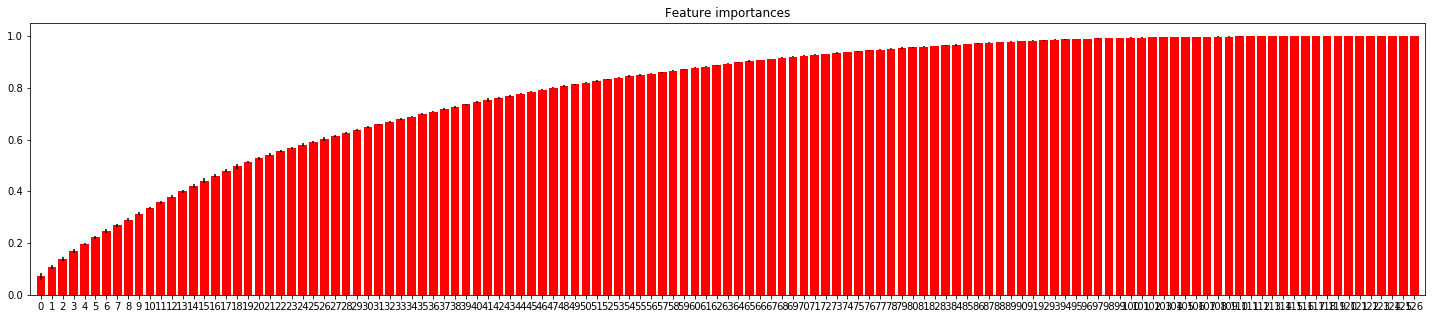

In [189]:
importances_pd['importance_cumsum'] = importances_pd['feature_importance'].cumsum()

plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(len(importances_pd['importance_cumsum'])),y,color="r", yerr=std[indices], align="center")
plt.xticks(importances_pd['feature_index'], indices)
plt.xlim([-1, len(importances)])
plt.show()


In [190]:
features_80percent = importances_pd.loc[importances_pd['importance_cumsum'] <= 0.8]['feature_index']

In [191]:
train_engineered_pd = train_pd.loc[:, ~train_pd.columns.isin(['Target'])].iloc[:,features_80percent]
train_engineered_pd['Target'] = train_pd['Target']

## Random forest with engineered data

In [192]:
rf_model_engineered = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=0, warm_start=False)
rf_scores_engineered, rf_best_engineered, cm_rf_engineered = CV_monte_carlo(rf_model_engineered, 
                                                                            training_data=train_engineered_pd)

Min/Mean/Max F1-Score = 0.901750 / 0.920346 / 0.936022 


In [228]:
# confusion matrix
100 * cm_rf_engineered / cm_rf_engineered.sum(axis=1)[:, np.newaxis]

array([[92.45283019,  4.40251572,  1.25786164,  1.88679245],
       [ 1.48809524, 90.77380952,  1.78571429,  5.95238095],
       [ 0.        ,  4.72103004, 88.41201717,  6.86695279],
       [ 0.16891892,  0.84459459,  0.25337838, 98.73310811]])

## Grid Search

In [357]:
# prepare trainings data

# split
input_train, input_test, \
target_train, target_test = train_test_split(train_engineered_pd.loc[:, ~train_engineered_pd.columns.isin(['Target'])].values, 
                                             train_engineered_pd['Target'].values, test_size=1-0.8)
input_train_rs, target_train_rs = naive_resample(input_train, target_train)
input_train_smote, target_train_smote = SMOTE_resample(input_train, target_train)
        
        
grid_dict = {0: 'Random Forest', 1: 'XGboost'}
best_f1 = 0.0
for idx, gs in enumerate(grids):
    print("Estimator: %s" % grid_dict[idx])
    # Fit grid search
    gs.fit(input_train_rs, target_train_rs)
    print('Best params: %s' % gs.best_params_)
    print('Best training F1 score: %.3f' % gs.best_score_)
    y_pred = gs.predict(input_test)
    metric = f1_score(target_test, y_pred, average="macro")
    print('Test set F1 score for best params: %.3f ' % metric)
    if metric > best_f1:
        best_f1 = metric
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Estimator: Random Forest
Best params: {'rf__n_estimators': 50}
Best training F1 score: 0.999
Test set F1 score for best params: 0.985 
Estimator: XGboost


C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

Best params: {'xgboost__learning_rate': 1.0, 'xgboost__max_depth': 10, 'xgboost__n_estimators': 50}
Best training F1 score: 0.999
Test set F1 score for best params: 0.984 

Classifier with best test set accuracy: Random Forest


## AdaBoost

In [194]:
adaboost_model =  AdaBoostClassifier(n_estimators=100)
adaboost_scores, adaboost_best, cm_adaboost = CV_monte_carlo(adaboost_model, training_data=train_pd)

Min/Mean/Max F1-Score = 0.423875 / 0.444823 / 0.469937 


In [231]:
# confusion matrix
100 * cm_adaboost / cm_adaboost.sum(axis=1)[:, np.newaxis]

array([[54.05405405, 20.94594595, 16.21621622,  8.78378378],
       [25.23364486, 37.38317757, 24.29906542, 13.08411215],
       [19.4092827 , 15.18987342, 41.35021097, 24.05063291],
       [ 7.13101161,  8.54063018, 12.68656716, 71.64179104]])

## AdaBoost with engineered data

In [196]:
adaboost_model_engineered =  AdaBoostClassifier(n_estimators=100)
adaboost_scores_engineered, adaboost_best_engineered, cm_adaboost_engineered = CV_monte_carlo(adaboost_model_engineered, 
                                                                      training_data=train_engineered_pd)

Min/Mean/Max F1-Score = 0.427184 / 0.442710 / 0.465420 


In [232]:
# confusion matrix
100 * cm_adaboost_engineered / cm_adaboost_engineered.sum(axis=1)[:, np.newaxis]

array([[61.74496644, 16.77852349, 12.08053691,  9.39597315],
       [29.20353982, 33.03834808, 22.12389381, 15.63421829],
       [19.52191235, 16.73306773, 43.42629482, 20.3187251 ],
       [ 7.58738278,  7.07587383, 16.70929241, 68.62745098]])

## Gradient Tree Boosting

In [ ]:
gtb_model = GradientBoostingClassifier(n_estimators=130, learning_rate=2, max_depth=5, random_state=0)
gtb_scores, gtb_best = CV_monte_carlo(gtb_model, training_data=train_pd)

## Gradient Tree Boosting with engineered data

In [ ]:
gtb_model_engineered = GradientBoostingClassifier(n_estimators=130, learning_rate=2, max_depth=5, random_state=0)
gtb_scores_engineered, gtb_best_engineered = CV_monte_carlo(gtb_model_engineered, training_data=train_engineered_pd)

## XGBoost

In [244]:
xgboost_model = XGBClassifier(max_depth=100, n_estimators=100, learning_rate=1, n_jobs=50, booster='gbtree')
xgboost_scores, xgboost_best, cm_xgboost = CV_monte_carlo(xgboost_model, N=4, training_data=train_pd)

C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Min/Mean/Max F1-Score = 0.899049 / 0.910866 / 0.924994 


C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [246]:
# confusion matrix
100 * cm_xgboost / cm_xgboost.sum(axis=1)[:, np.newaxis]

array([[88.23529412,  4.5751634 ,  0.        ,  7.18954248],
       [ 2.45398773, 86.80981595,  3.37423313,  7.36196319],
       [ 0.41666667,  3.33333333, 91.25      ,  5.        ],
       [ 0.        ,  0.33528919,  0.75440067, 98.91031014]])

## XGBoost witn engineered data

In [247]:
xgboost_model_engineered = XGBClassifier(max_depth=100, n_estimators=100, learning_rate=1, n_jobs=50, booster='gbtree')
xgboost_scores_engineered, xgboost_best_engineered, cm_xgboost_engineered = CV_monte_carlo(xgboost_model_engineered, N=4, 
                                                                    training_data=train_engineered_pd)

C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Min/Mean/Max F1-Score = 0.914210 / 0.920771 / 0.929155 


C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [248]:
# confusion matrix
100 * cm_xgboost_engineered / cm_xgboost_engineered.sum(axis=1)[:, np.newaxis]

array([[8.96103896e+01, 8.44155844e+00, 6.49350649e-01, 1.29870130e+00],
       [3.21428571e+00, 9.25000000e+01, 1.78571429e+00, 2.50000000e+00],
       [1.65289256e+00, 2.89256198e+00, 8.88429752e+01, 6.61157025e+00],
       [8.09061489e-02, 7.28155340e-01, 4.04530744e-01, 9.87864078e+01]])

# Define the network

In [351]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.utils import vis_utils

# define custom F1 metric
# taken from https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

class Metrics(Callback):
    def __init__(self):
        self.metric_optimal = 0
        self.cm = None
    
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        # Pdb().set_trace()
        _val_f1 = f1_score(val_targ, val_predict, average="macro")
        _val_recall = recall_score(val_targ, val_predict, average="macro")
        _val_precision = precision_score(val_targ, val_predict, average="macro")

        if _val_f1 > self.metric_optimal:
            # print(" - Best model found with f1 score = %f. Checkpointing"%_val_f1)
            self.metric_optimal = _val_f1
            self.model.save(self.model.name+'.h5')
            # compute the confusion matrix
            # self.cm = confusion_matrix(val_predict, val_targ)
            
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        # print(" - val_f1: %f | val_precision: %f | val_recall %f"%(_val_f1, _val_precision, _val_recall))
        return
    
    def on_train_end(self, logs={}):
        print('Best F1-Score for model %s = %f'%(self.model.name, self.metric_optimal))
        
def create_model(model_object, name):
    model_object.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    model_object.name = name
    return model_object

all_models_full_dataset = [
    create_model(Sequential([
        Dense(units=60, input_shape=(127,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        # Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.3),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.3),
        Dense(units=10, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.3),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ]), name='model_v1')
]

all_models_engineered_dataset = [
    create_model(Sequential([
        Dense(units=60, input_shape=(49,), activation='relu', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.3),
        Dense(units=40, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.3),
        Dense(units=20, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.3),
        Dropout(rate=0.3),
        Dense(units=10, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform'),
        Dropout(rate=0.3),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform')
    ]), name='model_v1')
]


category_mapping = {1: np.array([0, 0,0,1]), 2:np.array([0, 0,1,0]), 3:np.array([0, 1,0,0]), 4:np.array([1,0,0,0])}


### Run with full dataset

In [326]:
x_train, x_test, \
        y_train, y_test = train_test_split(train_pd.loc[:, ~train_pd.columns.isin(['Target'])].values, 
                                                     train_pd['Target'].values, test_size=1-0.8)
  

x_train_rs, y_train_rs = naive_resample(x_train, y_train)
x_train_smote, y_train_smote = SMOTE_resample(x_train, y_train)


In [323]:
for m in all_models_full_dataset:
    print("Running model: %s"%m.name)
    m.fit(x_train_rs, np.array([category_mapping[x] for x in y_train_rs]), 
          validation_data = (x_test, np.array([category_mapping[x] for x in y_test])),
          epochs = 100, batch_size = 120,verbose = 0, callbacks = [Metrics()])

Running model: model_v1


C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best F1-Score for model model_v1 = 0.541286


### Add the labels from the RF as features

In [345]:
# add the RF labels as features
if 'rf_label' in train_engineered_pd:
    del train_engineered_pd['rf_label']
    
if 'xgboost_label' in train_engineered_pd:
    del train_engineered_pd['xgboost_label']

rf_label = rf_model_engineered.predict(train_engineered_pd.loc[:, ~train_engineered_pd.columns.isin(['Target'])].values)
xgboost_label = xgboost_best_engineered.predict(train_engineered_pd.loc[:, ~train_engineered_pd.columns.isin(['Target'])].values)

train_engineered_pd['rf_label'] = rf_label
train_engineered_pd['xgboost_label'] = xgboost_label

x_train, x_test, \
        y_train, y_test = train_test_split(train_engineered_pd.loc[:, ~train_engineered_pd.columns.isin(['Target'])].values, 
                                                     train_engineered_pd['Target'].values, test_size=1-0.8)
  

x_train_rs, y_train_rs = naive_resample(x_train, y_train)
x_train_smote, y_train_smote = SMOTE_resample(x_train, y_train)



C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [339]:
for m in all_models_engineered_dataset:
    print("Running model: %s"%m.name)
    m.fit(x_train_rs, np.array([category_mapping[x] for x in y_train_rs]), 
          validation_data = (x_test, np.array([category_mapping[x] for x in y_test])),
          epochs = 200, batch_size = 200,verbose = 0, callbacks = [Metrics()])

Running model: model_v1


C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best F1-Score for model model_v1 = 0.848562


In [352]:
for m in all_models_engineered_dataset:
    print("Running model: %s"%m.name)
    m.fit(x_train_rs, np.array([category_mapping[x] for x in y_train_rs]), 
          validation_data = (x_test, np.array([category_mapping[x] for x in y_test])),
          epochs = 200, batch_size = 200,verbose = 0, callbacks = [Metrics()])

Running model: model_v1


C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best F1-Score for model model_v1 = 0.853186
